# Оптимизация маркетинговых затрат Яндекс.Афиши

## Описание проекта

Есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

## Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = (16,16)

In [3]:
# Загрузка файла visits_log.csv, оптимизация типа данных и названий столбцов
visits = pd.read_csv('datasets/visits_log.csv', parse_dates = ['End Ts', 'Start Ts'])
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


Таблица visits (лог сервера с информацией о посещениях сайта):

- uid — уникальный идентификатор пользователя
- device — категория устройства пользователя
- start_ts — дата и время начала сессии
- end_ts — дата и время окончания сессии
- source_id — идентификатор рекламного источника, из которого пришел пользователь

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [5]:
# Загрузка файла orders_log.csv, оптимизация типа данных и названий столбцов
orders = pd.read_csv('datasets/orders_log.csv', parse_dates = ['Buy Ts'])
orders.columns = ['buy_ts', 'revenue', 'uid']
orders

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


Таблица orders (информация о заказах):

- uid — уникальный id пользователя, который сделал заказ
- buy_ts — дата и время заказа
- revenue — выручка Яндекс.Афиши с этого заказа

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [7]:
# Загрузка файла costs.csv, оптимизация типа данных
costs = pd.read_csv('datasets/costs.csv', parse_dates = ['dt'])
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


Таблица costs (информация о затратах на маркетинг):

- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


<B>Датасеты загружены, типы данных преведены к типу datetime там где это необходимо, названия столбцов приведены к единообразному виду, пропусков нет, можно работать.</B>

## Шаг 2. Построение отчетов и подсчет метрик

### 2.1. Продукт

Посчитаем метрики пользовательской активности MAU, WAU и DAU

In [9]:
# Выделим столбцы с годом, месяцем, неделей и датой сессии
visits['year'] = visits['start_ts'].dt.year
visits['month'] = visits['start_ts'].dt.month
visits['week'] = visits['start_ts'].dt.week
visits['date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [10]:
# Посчитаем кол-во сессий на одного пользователя
sessions_per_user = visits.groupby(['year', 'month']).agg({'uid' : ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

n_sessions  n_users  sess_per_user
year month                                    
2017 6           16505    13259       1.244815
     7           17828    14183       1.256998
     8           14355    11631       1.234202
     9           23907    18975       1.259921
     10          37903    29692       1.276539
     11          43969    32797       1.340641
     12          41983    31557       1.330386
2018 1           36939    28716       1.286356
     2           37182    28749       1.293332
     3           35679    27473       1.298693
     4           26515    21008       1.262138
     5           26635    20701       1.286653

<b>Кол-во сессий на одного пользователя невелико, чуть более 1.2 и не растет </b>

In [11]:
# Посчитаем MAU
mau = visits.groupby(['year', 'month']).agg({'uid' : 'nunique'})
mau

uid
year month       
2017 6      13259
     7      14183
     8      11631
     9      18975
     10     29692
     11     32797
     12     31557
2018 1      28716
     2      28749
     3      27473
     4      21008
     5      20701

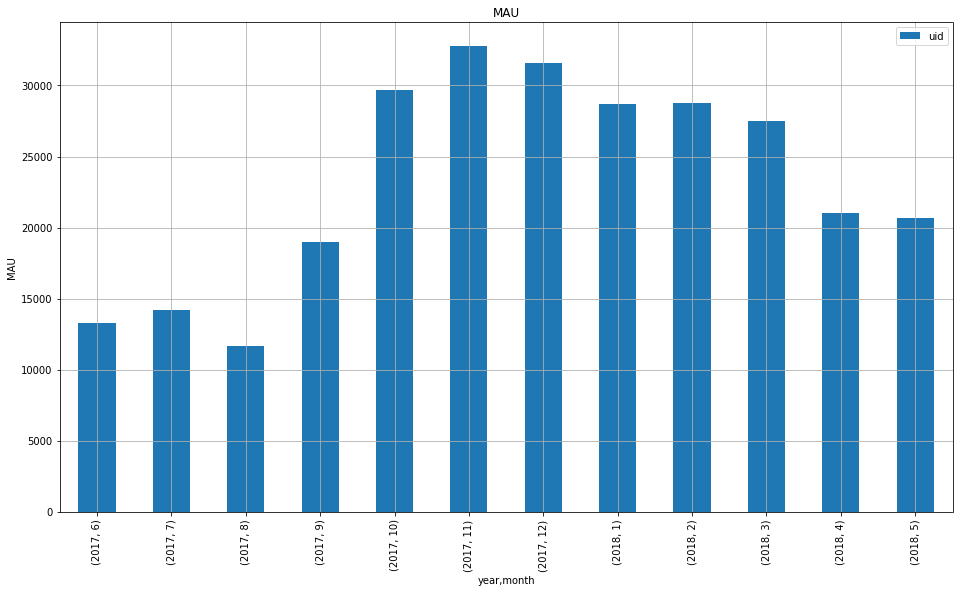

In [12]:
# Построим график MAU по месяцам
mau.plot(kind = 'bar', grid = True,
               title = 'MAU', figsize = (16, 9))
plt.ylabel('MAU')
plt.show()

In [13]:
# Посчитаем среднюю MAU
mau_mean = mau.mean()
mau_mean

uid    23228.416667
dtype: float64

<B>Средняя MAU составляет 23288 уникальных пользователей в месяц.</B> В летние месяцы 2017 года показатель был ниже, ниже 15 тыс пользователей, возможно из-за летнего периода отпусков, но вырос к концу года. В начале 2018 года был стабилен в районе 30 тыс пользователей, затем с апреля стал снижаться до 20 тыс. 

In [14]:
# Посчитаем среднюю WAU
wau_mean = visits.groupby(['year', 'week']).agg({'uid' : 'nunique'}).mean()
wau_mean

uid    5716.245283
dtype: float64

Средняя WAU составляет 5716 человек в неделю.

In [15]:
# Посчитаем среднюю DAU
dau_mean = visits.groupby(['year', 'date']).agg({'uid' : 'nunique'}).mean()
dau_mean

uid    907.991758
dtype: float64

<b>В день сервисом пользуются в среднем 908 уникальных посетителей.</b>

In [16]:
# Посчитаем sticky factor за неделю
sticky_wau = dau_mean / wau_mean * 100
sticky_wau

uid    15.884409
dtype: float64

In [17]:
# Посчитаем sticky factor за месяц
sticky_mau = dau_mean / mau_mean * 100
sticky_mau

uid    3.90897
dtype: float64

Данные метрики на мой взгляд немного ниже нормальных.

In [18]:
# Посчитаем среднее кол-во сессий в день
sessions_mean = visits.groupby(['year', 'date']).agg({'start_ts' : 'count'}).mean()
sessions_mean

start_ts    987.362637
dtype: float64

<b>В среднем в день происходит 987 сессий доступа к сервису.</b>

In [19]:
# Добавим столбец с длительностью сессии
visits['duration'] = visits['end_ts'] - visits['start_ts']
visits.head(3)

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,00:18:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,00:28:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,00:00:00


In [20]:
# Посчитаем среднюю величину длительности
visits['duration'].mean(numeric_only = False)

Timedelta('0 days 00:10:43.025687')

In [21]:
# Переведем столбец с длительностью в секунды
visits['duration'] = visits['duration'].astype('timedelta64[s]')

In [22]:
# Исключим нулевые сессии
good_visits = visits[visits['duration'] > 0].copy()
good_visits

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,1,5,2018-01-30,3360.0
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29,19.0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25,19.0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03,19.0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02,19.0


In [23]:
# Посчитаем среднюю длительность сессий каждый день
duration_mean = good_visits.groupby(['date'])['duration'].mean()
duration_mean

date
2017-06-01    738.626043
2017-06-02    684.320470
2017-06-03    674.869464
2017-06-04    632.434004
2017-06-05    690.996283
                 ...    
2018-05-27    643.092784
2018-05-28    702.727185
2018-05-29    691.569002
2018-05-30    714.148617
2018-05-31    810.530355
Name: duration, Length: 364, dtype: float64

In [24]:
good_visits['duration'].mean()

714.1695158279873

Исключив нулевые и отрицательные сессии получилось, что <b>средняя сессия длится около 12 минут</b>.

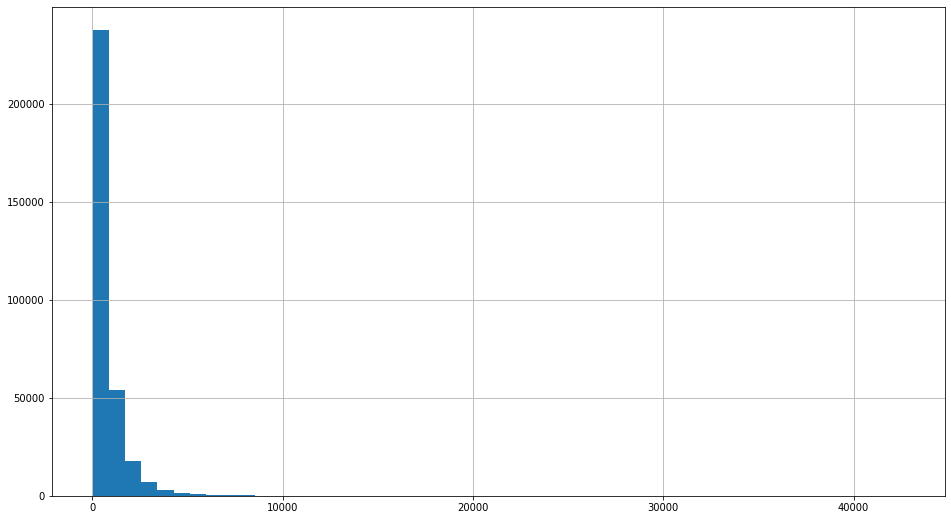

In [25]:
# Построим гистограмму длительности сессий
good_visits['duration'].hist(bins = 50, figsize = (16, 9))
plt.show()

In [26]:
good_visits['duration'].describe()

count    323604.000000
mean        714.169516
std        1026.349417
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       42660.000000
Name: duration, dtype: float64

Видно что в данных по длительности сессий много выбросов. Возможно кто-то прекращал пользоваться сайтом и не закрывал окно браузера, отсюда очень длинные сессии.

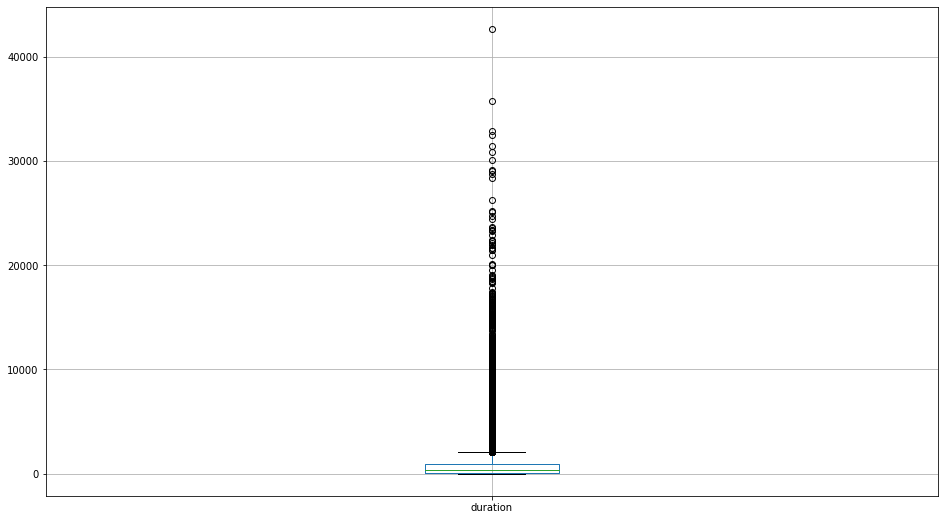

In [27]:
# Построим boxplot длительности сессий
good_visits.boxplot(column = 'duration', figsize = (16, 9))
plt.show()

In [28]:
# Ограничим диапазон сессий, чтобы избавиться от выбросов
good_visits = good_visits[good_visits['duration'] <= 2000]
good_visits

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017,11,44,2017-11-05,60.0
...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29,19.0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25,19.0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03,19.0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02,19.0


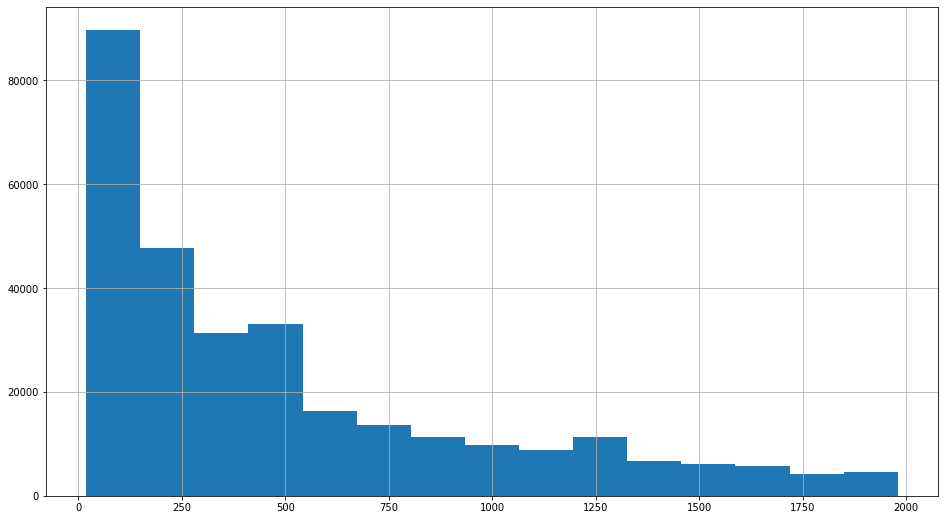

In [29]:
# Построим гистограмму по очищенным данным
good_visits['duration'].hist(bins = 15, figsize = (16, 9))
plt.show()

In [30]:
good_visits['duration'].describe()

count    300259.000000
mean        505.041154
std         486.416928
min          19.000000
25%         120.000000
50%         300.000000
75%         780.000000
max        1980.000000
Name: duration, dtype: float64

In [31]:
# Посчитаем медиану
good_visits['duration'].median()

300.0

In [32]:
# Посчитаем моду
good_visits['duration'].mode()

0    60.0
dtype: float64

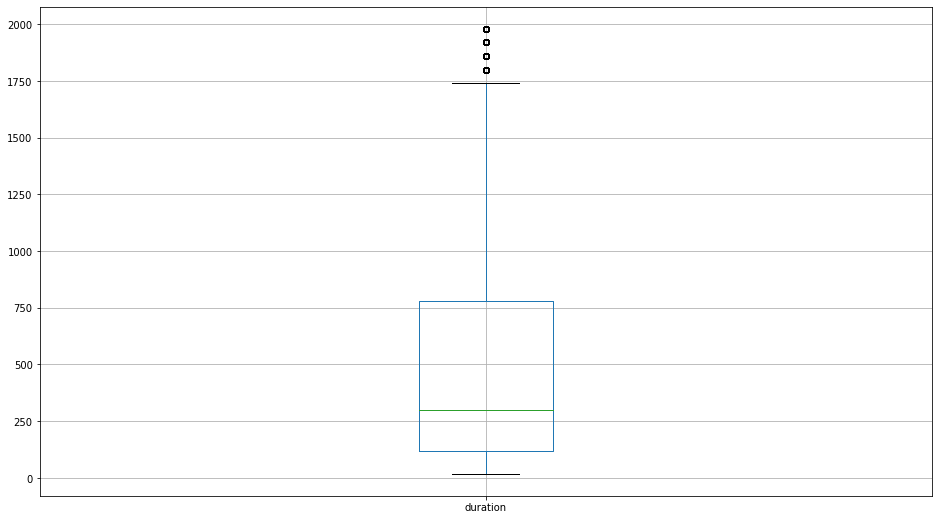

In [33]:
# Построим boxplot по очиченным от выбросов данным длительности сессий
good_visits.boxplot(column = 'duration', figsize = (16, 9))
plt.show()

Даже после чистки выбросов в длительности сессий, однозначно сказать сколько длится одна сессия нельзя. Средняя температура по больнице 505 секунд (8 с половиной минут), медиана 300 секунд (5 минут), мода 60 секунд - наиболее часто встречающееся значение.

Я бы сказал что большинство сессий имеют длительность от 19 секунд до 13 минут.

Google аналитика считает ASL как среднее значение. По нашим данным (очищенным) <b>ASL будет 505 секунд (или 8.4 минуты)</b> - это неплохой показатель, но мог быть и выше.

In [34]:
# Определим дату первой сессии для каждого пользователя
first_visits = visits.groupby('uid')['start_ts'].min()
first_visits.name = 'first_visits_datetime'
first_visits

uid
11863502262781         2018-03-01 17:27:00
49537067089222         2018-02-06 15:55:00
297729379853735        2017-06-07 18:47:00
313578113262317        2017-09-18 22:49:00
325320750514679        2017-09-30 14:29:00
                               ...        
18446403737806311543   2017-11-30 03:36:00
18446424184725333426   2017-12-06 20:32:00
18446556406699109058   2018-01-01 16:29:00
18446621818809592527   2017-12-27 13:27:00
18446676030785672386   2017-10-04 16:01:00
Name: first_visits_datetime, Length: 228169, dtype: datetime64[ns]

In [35]:
# Соединим получившуюся таблицу с общей
visits = visits.join(first_visits, on = 'uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0,2017-12-27 14:06:00


In [36]:
# Переведем столбцы в нужный формат
visits['first_visits_month'] = visits['first_visits_datetime'].astype('datetime64[M]')
visits['visits_month'] = visits['start_ts'].astype('datetime64[M]')
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime,first_visits_month,visits_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0,2017-12-27 14:06:00,2017-12-01,2017-12-01


In [37]:
# Сгруппируем пользователей по когортам, в зависимости от месяца первой сессии
visits_grouped_by_cohorts = visits.groupby(['first_visits_month', 
                                                  'visits_month']).agg({'uid' : 'nunique'})
visits_grouped_by_cohorts

uid
first_visits_month visits_month       
2017-06-01         2017-06-01    13259
                   2017-07-01     1043
                   2017-08-01      713
                   2017-09-01      814
                   2017-10-01      909
...                                ...
2018-03-01         2018-04-01      861
                   2018-05-01      557
2018-04-01         2018-04-01    15709
                   2018-05-01      760
2018-05-01         2018-05-01    15273

[78 rows x 1 columns]

In [38]:
visits_grouped_by_cohorts

uid
first_visits_month visits_month       
2017-06-01         2017-06-01    13259
                   2017-07-01     1043
                   2017-08-01      713
                   2017-09-01      814
                   2017-10-01      909
...                                ...
2018-03-01         2018-04-01      861
                   2018-05-01      557
2018-04-01         2018-04-01    15709
                   2018-05-01      760
2018-05-01         2018-05-01    15273

[78 rows x 1 columns]

In [39]:
visits['cohort_lifetime'] = visits['visits_month'] - visits['first_visits_month']
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime,first_visits_month,visits_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0 days
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0 days
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0 days
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,61 days
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0 days


In [40]:
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime,first_visits_month,visits_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


In [41]:
new_cohorts = visits.groupby(['first_visits_month', 'cohort_lifetime']).agg({'uid' : 'nunique'}).reset_index()
new_cohorts

,first_visits_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [42]:
initial_users_count = new_cohorts[new_cohorts['cohort_lifetime'] == 0][['first_visits_month', 'uid']]
initial_users_count = initial_users_count.rename(columns = {'uid' : 'cohort_users'})
initial_users_count

,first_visits_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [43]:
new_cohorts = new_cohorts.merge(initial_users_count, on = 'first_visits_month')
new_cohorts

,first_visits_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


In [44]:
# Посчитаем Retention Rate
new_cohorts['retention'] = new_cohorts['uid'] / new_cohorts['cohort_users']
new_cohorts

,first_visits_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.041818
74,2018-03-01,2,557,20589,0.027053
75,2018-04-01,0,15709,15709,1.000000
76,2018-04-01,1,760,15709,0.048380


In [45]:
new_retention_pivot = new_cohorts.pivot_table(index = 'first_visits_month',
                    columns = 'cohort_lifetime',
                    values = 'retention',
                    aggfunc = 'sum'
                   )
new_retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visits_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


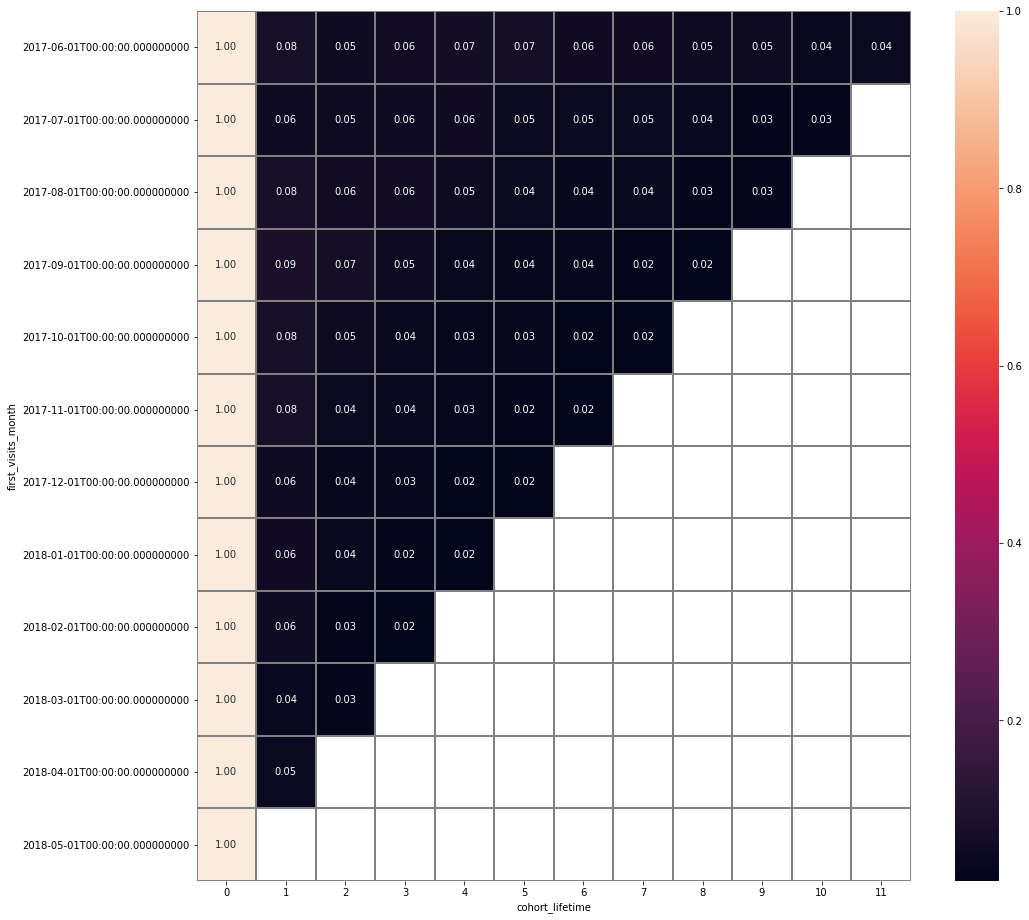

In [46]:
sns.heatmap(new_retention_pivot, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'gray')
plt.rcParams["figure.figsize"] = (16,16)
plt.show()

In [47]:
# Посчитаем коэффициент оттока Churn Rate
visits_grouped_by_cohorts['churn_rate'] = visits_grouped_by_cohorts['uid'].pct_change()
visits_grouped_by_cohorts

uid  churn_rate
first_visits_month visits_month                   
2017-06-01         2017-06-01    13259         NaN
                   2017-07-01     1043   -0.921336
                   2017-08-01      713   -0.316395
                   2017-09-01      814    0.141655
                   2017-10-01      909    0.116708
...                                ...         ...
2018-03-01         2018-04-01      861   -0.958182
                   2018-05-01      557   -0.353078
2018-04-01         2018-04-01    15709   27.202873
                   2018-05-01      760   -0.951620
2018-05-01         2018-05-01    15273   19.096053

[78 rows x 2 columns]

<b>Плохие показатели метрик Retention Rate и Churn Rate говорят о том, что либо с сервисом что-то не то (каждый месяц регистрируется много уникальных пользователей, но продолжают пользоваться им менее 10%, либо о том что плохой маркетинг - пользователям не напоминают о сервисе, и они забывают о нем и перестают пользоваться.

Следовательно, можно задействовать две стратегии: 
- протестировать и улучшить интерфейс сервиса, пользовательский опыт (особенно в мобильной версии)
- ежемесячно направлять зарегистрированным пользователям сервиса email рассылку с интересным и полезным контентом</b>

### 2.2. Продажи

In [48]:
orders

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [49]:
visits

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime,first_visits_month,visits_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29,19.0,2017-07-29 19:07:00,2017-07-01,2017-07-01,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25,19.0,2018-01-25 17:38:00,2018-01-01,2018-01-01,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03,19.0,2018-03-03 10:12:00,2018-03-01,2018-03-01,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02,19.0,2017-11-02 10:12:00,2017-11-01,2017-11-01,0


In [50]:
# Посчитаем конверсию по уникальным пользователям
orders['uid'].nunique() / visits['uid'].nunique()

0.16006994815246595

In [51]:
# Соедниним таблицы visits и orders
visits_with_orders = visits.merge(orders, how = 'left', on = 'uid')
visits_with_orders

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime,first_visits_month,visits_month,cohort_lifetime,buy_ts,revenue
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0,NaT,NaN
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0,NaT,NaN
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0,NaT,NaN
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,2,2018-03-09 20:25:00,2.33
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0.0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023808,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25,19.0,2018-01-25 17:38:00,2018-01-01,2018-01-01,0,2018-01-25 17:38:00,2.93
1023809,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25,19.0,2018-01-25 17:38:00,2018-01-01,2018-01-01,0,2018-01-25 22:29:00,0.37
1023810,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03,19.0,2018-03-03 10:12:00,2018-03-01,2018-03-01,0,2018-03-03 10:12:00,0.61
1023811,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02,19.0,2017-11-02 10:12:00,2017-11-01,2017-11-01,0,2017-11-02 10:12:00,2.69


In [52]:
#Избавимся от задублировавшихся значений
good_orders_visits = visits_with_orders[visits_with_orders['buy_ts'].notna()].drop_duplicates(subset = ['uid', 'buy_ts'])
good_orders_visits

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime,first_visits_month,visits_month,cohort_lifetime,buy_ts,revenue
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,2,2018-03-09 20:25:00,2.33
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53
7,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53
14,desktop,2018-02-06 15:50:00,4,2018-02-06 15:45:00,8056418121947262981,2018,2,6,2018-02-06,300.0,2017-06-04 14:17:00,2017-06-01,2018-02-01,8,2017-06-25 08:54:00,3.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021714,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017,12,49,2017-12-04,480.0,2017-12-04 12:42:00,2017-12-01,2017-12-01,0,2017-12-04 12:46:00,4.15
1021723,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017,11,47,2017-11-20,660.0,2017-11-20 23:33:00,2017-11-01,2017-11-01,0,2017-11-20 23:43:00,3.67
1021763,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017,11,48,2017-11-29,1260.0,2017-11-29 20:27:00,2017-11-01,2017-11-01,0,2017-11-29 20:33:00,3.05
1021805,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018,4,17,2018-04-23,480.0,2018-04-23 21:11:00,2018-04-01,2018-04-01,0,2018-04-23 21:16:00,0.49


Количество строк совпадает с изначальной таблицей orders, значит все соединилось правильно

In [53]:
# Выделим столбец с месяцем покупки
good_orders_visits['buy_month'] = good_orders_visits['buy_ts'].astype('datetime64[M]')
good_orders_visits

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime,first_visits_month,visits_month,cohort_lifetime,buy_ts,revenue,buy_month
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,2,2018-03-09 20:25:00,2.33,2018-03-01
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-01
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-10-01
7,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-10-01
14,desktop,2018-02-06 15:50:00,4,2018-02-06 15:45:00,8056418121947262981,2018,2,6,2018-02-06,300.0,2017-06-04 14:17:00,2017-06-01,2018-02-01,8,2017-06-25 08:54:00,3.67,2017-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021714,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017,12,49,2017-12-04,480.0,2017-12-04 12:42:00,2017-12-01,2017-12-01,0,2017-12-04 12:46:00,4.15,2017-12-01
1021723,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017,11,47,2017-11-20,660.0,2017-11-20 23:33:00,2017-11-01,2017-11-01,0,2017-11-20 23:43:00,3.67,2017-11-01
1021763,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017,11,48,2017-11-29,1260.0,2017-11-29 20:27:00,2017-11-01,2017-11-01,0,2017-11-29 20:33:00,3.05,2017-11-01
1021805,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018,4,17,2018-04-23,480.0,2018-04-23 21:11:00,2018-04-01,2018-04-01,0,2018-04-23 21:16:00,0.49,2018-04-01


In [54]:
# Посчитаем когорты покупателей
cohorts_buyers = good_orders_visits.groupby(['first_visits_month', 'buy_month']).agg({'revenue': 'sum', 'uid':'nunique'})
cohorts_buyers['ltv_customer'] = cohorts_buyers['revenue'] / cohorts_buyers['uid']
cohorts_buyers

revenue   uid  ltv_customer
first_visits_month buy_month                               
2017-06-01         2017-06-01   9557.49  2023      4.724414
                   2017-07-01   2664.58   231     11.534978
                   2017-08-01   1464.69   129     11.354186
                   2017-09-01   3882.09   188     20.649415
                   2017-10-01   3940.59   257     15.333035
...                                 ...   ...           ...
2018-03-01         2018-05-01    774.77    90      8.608556
2018-04-01         2018-04-01   8043.82  1763      4.562575
                   2018-05-01   1838.73   174     10.567414
2018-05-01         2018-05-01  10368.11  2315      4.478665
                   2018-06-01      3.42     1      3.420000

[79 rows x 3 columns]

In [55]:
# Посчитаем среднюю LTV одного покупателя
cohorts_buyers['ltv_customer'].mean()

9.22012263197559

<b>Средняя LTV для одного покупателя составляет 9.22</b>

In [56]:
cohorts_buyers.sort_values(by = 'revenue', ascending = False).head(10)

,,revenue,uid,ltv_customer
first_visits_month,buy_month,,,
2017-10-01,2017-10-01,18362.32,3761,4.882297
2017-12-01,2017-12-01,16857.00,3491,4.828702
2017-11-01,2017-11-01,16531.79,3357,4.924573
2017-09-01,2017-09-01,12357.20,2257,5.475055
2018-03-01,2018-03-01,12011.39,2663,4.510473
2018-02-01,2018-02-01,11512.63,2852,4.036687
2018-01-01,2018-01-01,10597.01,2644,4.007946
2017-09-01,2017-12-01,10438.93,178,58.645674
2018-05-01,2018-05-01,10368.11,2315,4.478665


Лучшие когорты приносят 16-18 тыс единиц дохода. Топ-10 укладываются в сумму до 10 тыс. единиц, остальные меньше.

In [57]:
# Составим сводную таблицу когорт покупателей по месяцам покупок для метрики LTV
cohorts_buyers_ltv = cohorts_buyers.pivot_table(index = 'first_visits_month',
                          columns = 'buy_month',
                          values = ['ltv_customer'])
cohorts_buyers_ltv

ltv_customer                                              \
buy_month            2017-06-01 2017-07-01 2017-08-01 2017-09-01 2017-10-01   
first_visits_month                                                            
2017-06-01             4.724414  11.534978  11.354186  20.649415  15.333035   
2017-07-01                  NaN   5.633137   7.846519   7.442282   6.382857   
2017-08-01                  NaN        NaN   5.161267   6.393077   7.256159   
2017-09-01                  NaN        NaN        NaN   5.475055  10.138301   
2017-10-01                  NaN        NaN        NaN        NaN   4.882297   
2017-11-01                  NaN        NaN        NaN        NaN        NaN   
2017-12-01                  NaN        NaN        NaN        NaN        NaN   
2018-01-01                  NaN        NaN        NaN        NaN        NaN   
2018-02-01                  NaN        NaN        NaN        NaN        NaN   
2018-03-01                  NaN        NaN        NaN        NaN        NaN   
2018-04-01                  NaN        NaN        NaN        NaN        NaN   
2018-05-01                  NaN        NaN        NaN        NaN        NaN   

                                                                           \
buy_month          2017-11-01 2017-12-01 2018-01-01 2018-02-01 2018-03-01   
first_visits_month                                                          
2017-06-01          13.913695  18.465344  14.650387  13.476221  22.318205   
2017-07-01           5.535882   6.000602   4.819672   6.017969   6.300174   
2017-08-01           8.087265   7.864466   7.011842   6.403289  14.491047   
2017-09-01           8.757801  58.645674  11.607928  13.643214   6.906000   
2017-10-01           8.003845   4.544589   5.370812   5.270051   5.775085   
2017-11-01           4.924573   4.797806   5.105894   7.483770   5.516119   
2017-12-01                NaN   4.828702   5.269788  22.213228  27.400107   
2018-01-01                NaN        NaN   4.007946   6.099063   6.655771   
2018-02-01                NaN        NaN        NaN   4.036687   7.062135   
2018-03-01                NaN        NaN        NaN        NaN   4.510473   
2018-04-01                NaN        NaN        NaN        NaN        NaN   
2018-05-01                NaN        NaN        NaN        NaN        NaN   

                                                     
buy_month          2018-04-01 2018-05-01 2018-06-01  
first_visits_month                                   
2017-06-01          19.333421  11.543772        NaN  
2017-07-01           8.208750   6.228800        NaN  
2017-08-01          15.672453   6.477931        NaN  
2017-09-01           7.121449   4.500753        NaN  
2017-10-01           4.990603   5.332520        NaN  
2017-11-01           6.492018   5.415504        NaN  
2017-12-01          16.753678  14.372016        NaN  
2018-01-01           3.871899   5.860778        NaN  
2018-02-01           6.698889   8.500094        NaN  
2018-03-01           5.377049   8.608556        NaN  
2018-04-01           4.562575  10.567414        NaN  
2018-05-01                NaN   4.478665       3.42

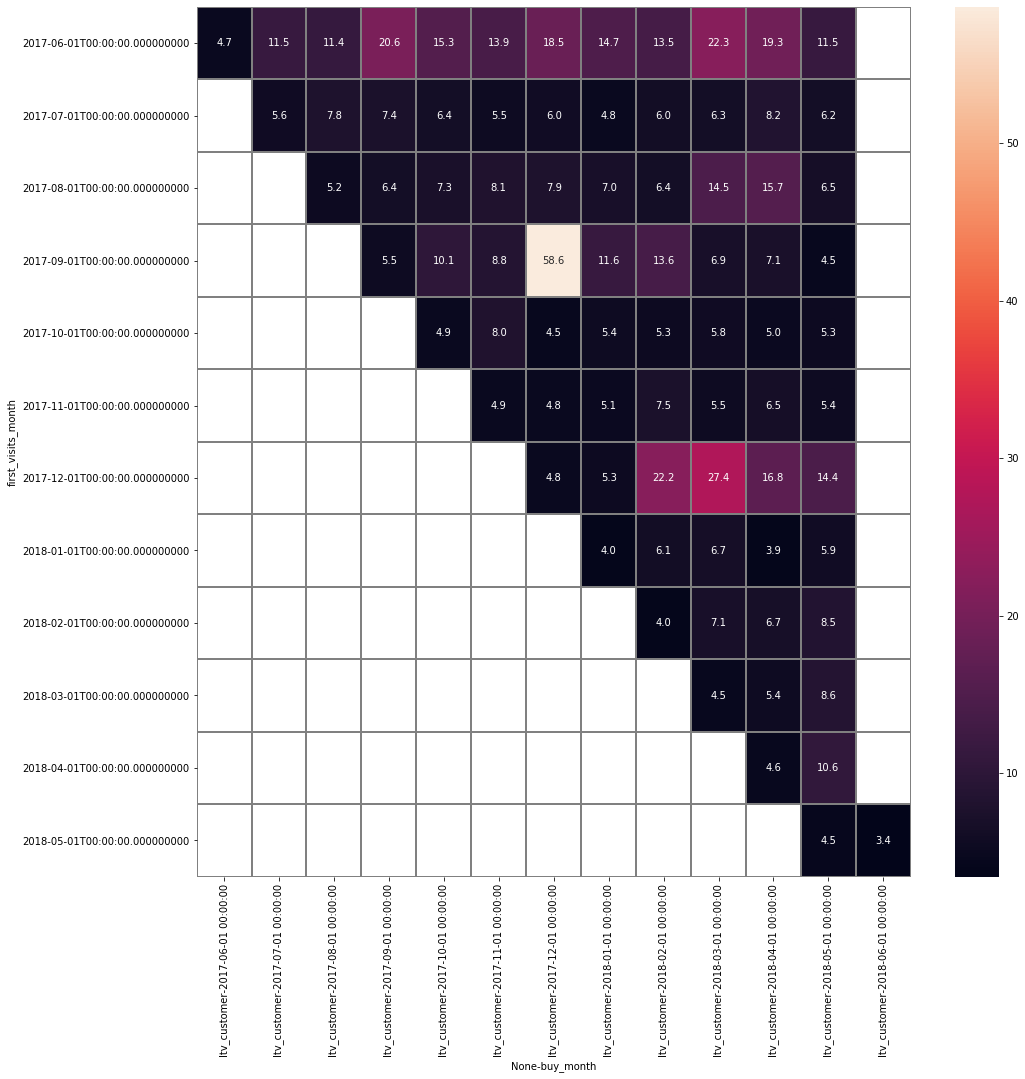

In [58]:
# Построим тепловую карту
sns.heatmap(cohorts_buyers_ltv, annot = True, fmt = '.1f', linewidths = 1, linecolor = 'gray')
plt.rcParams["figure.figsize"] = (16,16)
plt.show()

<B>В первый же месяц использования сервиса, часть посетителей начинают совершать покупки. На второй месяц и далее с течением времени их активность снижается.</B>

У когорты июня 2017 года показатели LTV лучше остальных: на протяжении нескольких месяцев - стабильные покупки на определенную сумму. Эта когорта приносит большее кол-во денег.

У когорты сентября 2017 года всплеск покупок в декабре.
У декабрьской когорты 2017 года показатели LTV в феврале-марте 2018 года лучше остальных.

<a id='001'></a>

In [59]:
# Посчитаем время после первого входа, когда покупатели делали заказ
good_orders_visits['buy_timedelta'] = good_orders_visits['buy_ts'] - good_orders_visits['first_visits_datetime']
good_orders_visits['buy_timedelta'].describe()

count                      50415
mean     37 days 00:53:06.287414
std      70 days 14:39:40.373203
min              0 days 00:00:00
25%              0 days 00:06:00
50%              0 days 03:26:00
75%             38 days 09:22:30
max            364 days 08:29:00
Name: buy_timedelta, dtype: object

<b>Больше половины покупателей начинают делать покупки в первый день пользователей сервисом.</b> Еще 25% в течение полутора месяцев, но есть и уникумы, которые совершают первую покупку через год!

In [60]:
visits_with_orders.head(3)

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime,first_visits_month,visits_month,cohort_lifetime,buy_ts,revenue
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0,NaT,NaN
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0,NaT,NaN
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0,NaT,NaN


In [61]:
good_orders_visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration,first_visits_datetime,first_visits_month,visits_month,cohort_lifetime,buy_ts,revenue,buy_month,buy_timedelta
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,2,2018-03-09 20:25:00,2.33,2018-03-01,0 days 00:20:00
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-01,0 days 15:11:00
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-10-01,54 days 02:26:00
7,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,9,35,2017-09-03,60.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-10-01,54 days 21:41:00
14,desktop,2018-02-06 15:50:00,4,2018-02-06 15:45:00,8056418121947262981,2018,2,6,2018-02-06,300.0,2017-06-04 14:17:00,2017-06-01,2018-02-01,8,2017-06-25 08:54:00,3.67,2017-06-01,20 days 18:37:00


In [62]:
# Почситаем процент повторных покупателей по каждой когорте
customers_count = good_orders_visits.groupby('buy_month').agg({'uid' : ['count', 'nunique']})
customers_count.columns = ['total', 'unique']
customers_count['return_customers_rate'] = 1 - (customers_count['unique'] / customers_count['total'])
customers_count

,total,unique,return_customers_rate
buy_month,,,
2017-06-01,2354,2023,0.140612
2017-07-01,2363,1984,0.160389
2017-08-01,1807,1472,0.185390
2017-09-01,3387,2750,0.188072
2017-10-01,5679,4675,0.176792
2017-11-01,5659,4547,0.196501
2017-12-01,6218,4942,0.205211
2018-01-01,4721,3898,0.174327
2018-02-01,5281,4258,0.193713


In [63]:
# Посчитаем средний процент повторных покупателей
customers_count['return_customers_rate'].mean()

0.16785796756453022

<b>Доля повторных клиентов в среднем составляет около 17%</b>

In [64]:
# Посчитаем количество и сумму покупок по каждой когорте
cohort_customers_count = good_orders_visits.groupby(['first_visits_month', 'buy_month']).agg({'uid' : 'count', 'revenue' : 'sum'})

cohort_customers_count.reset_index(inplace = True)
cohort_customers_count.columns = ['first_visits_month', 'buy_month', 'purchases_qty', 'revenue_sum']
cohort_customers_count

,first_visits_month,buy_month,purchases_qty,revenue_sum
0,2017-06-01,2017-06-01,2354,9557.49
1,2017-06-01,2017-07-01,387,2664.58
2,2017-06-01,2017-08-01,273,1464.69
3,2017-06-01,2017-09-01,442,3882.09
4,2017-06-01,2017-10-01,516,3940.59
...,...,...,...,...
74,2018-03-01,2018-05-01,201,774.77
75,2018-04-01,2018-04-01,1946,8043.82
76,2018-04-01,2018-05-01,339,1838.73
77,2018-05-01,2018-05-01,2476,10368.11


In [65]:
# Посчитаем средний чек по каждой когорте
cohort_customers_count['mean_purchase'] = cohort_customers_count['revenue_sum'] / cohort_customers_count['purchases_qty']
cohort_customers_count

,first_visits_month,buy_month,purchases_qty,revenue_sum,mean_purchase
0,2017-06-01,2017-06-01,2354,9557.49,4.060106
1,2017-06-01,2017-07-01,387,2664.58,6.885220
2,2017-06-01,2017-08-01,273,1464.69,5.365165
3,2017-06-01,2017-09-01,442,3882.09,8.783009
4,2017-06-01,2017-10-01,516,3940.59,7.636802
...,...,...,...,...,...
74,2018-03-01,2018-05-01,201,774.77,3.854577
75,2018-04-01,2018-04-01,1946,8043.82,4.133515
76,2018-04-01,2018-05-01,339,1838.73,5.423982
77,2018-05-01,2018-05-01,2476,10368.11,4.187443


In [66]:
# Посчитаем кол-во покупок по когортам по месяцам
cohort_purchases = cohort_customers_count.pivot_table(index = 'first_visits_month',
                                  columns = 'buy_month',
                                  values = ('purchases_qty'))
cohort_purchases

buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_visits_month,,,,,,,,,,,,,
2017-06-01,2354.0,387.0,273.0,442.0,516.0,428.0,500.0,329.0,371.0,318.0,185.0,294.0,NaN
2017-07-01,NaN,1976.0,184.0,204.0,196.0,192.0,170.0,142.0,156.0,151.0,87.0,87.0,NaN
2017-08-01,NaN,NaN,1350.0,221.0,205.0,179.0,162.0,107.0,102.0,145.0,83.0,84.0,NaN
2017-09-01,NaN,NaN,NaN,2520.0,492.0,329.0,275.0,135.0,192.0,194.0,97.0,112.0,NaN
2017-10-01,NaN,NaN,NaN,NaN,4270.0,619.0,356.0,235.0,245.0,219.0,131.0,158.0,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,3912.0,766.0,369.0,317.0,304.0,140.0,175.0,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,3989.0,464.0,262.0,250.0,113.0,158.0,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2940.0,452.0,255.0,94.0,123.0,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3184.0,413.0,130.0,139.0,NaN


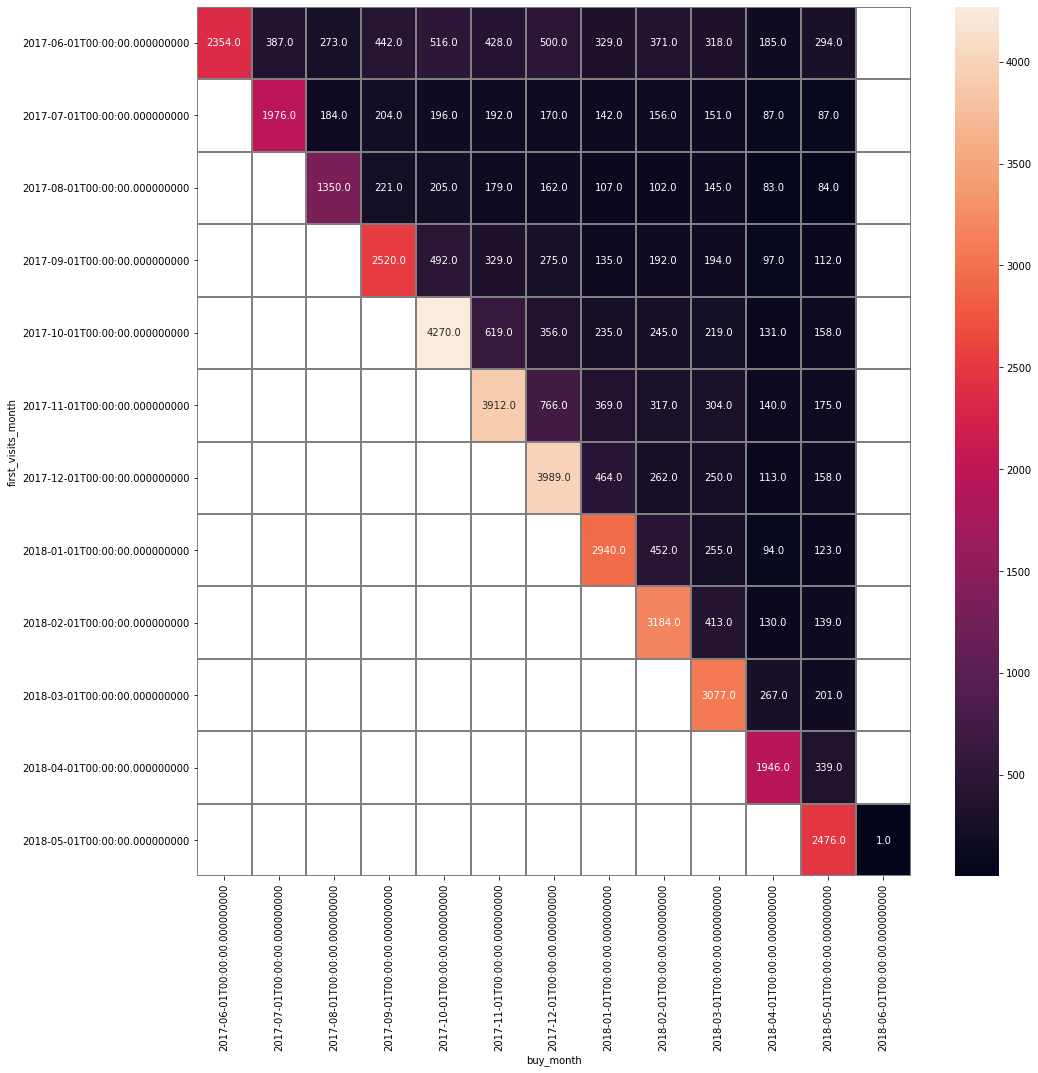

In [67]:
# Построим тепловую карту кол-ва покупок по месяцам
sns.heatmap(cohort_purchases, annot = True, fmt = '.1f', linewidths = 1, linecolor = 'gray')
plt.rcParams["figure.figsize"] = (16,16)
plt.show()

<b>Данные свидетельствуют о том, что основная масса пользователей делает покупки в первый месяц, в последующие месяцы кол-во покупок крайне мало</b>

In [68]:
# Посчитаем средний чек
orders['revenue'].mean()

4.999646930476993

<b>Средний чек составляет 4.99</b>

In [69]:
new_orders = orders.copy()
new_orders.head(3)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


In [70]:
new_orders['buy_year'] = new_orders['buy_ts'].dt.year
new_orders['buy_month'] = new_orders['buy_ts'].dt.month
new_orders.head()

,buy_ts,revenue,uid,buy_year,buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,6
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,6
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,6
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,6
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,6


In [71]:
new_orders_pivot = new_orders.groupby('buy_month')['revenue'].mean().reset_index()
new_orders_pivot = new_orders_pivot.set_index('buy_month')
new_orders_pivot

,revenue
buy_month,
1,4.112927
2,4.840095
3,5.413930
4,5.150645
5,4.771279
6,4.059834
7,5.306589
8,4.847139
9,5.416448


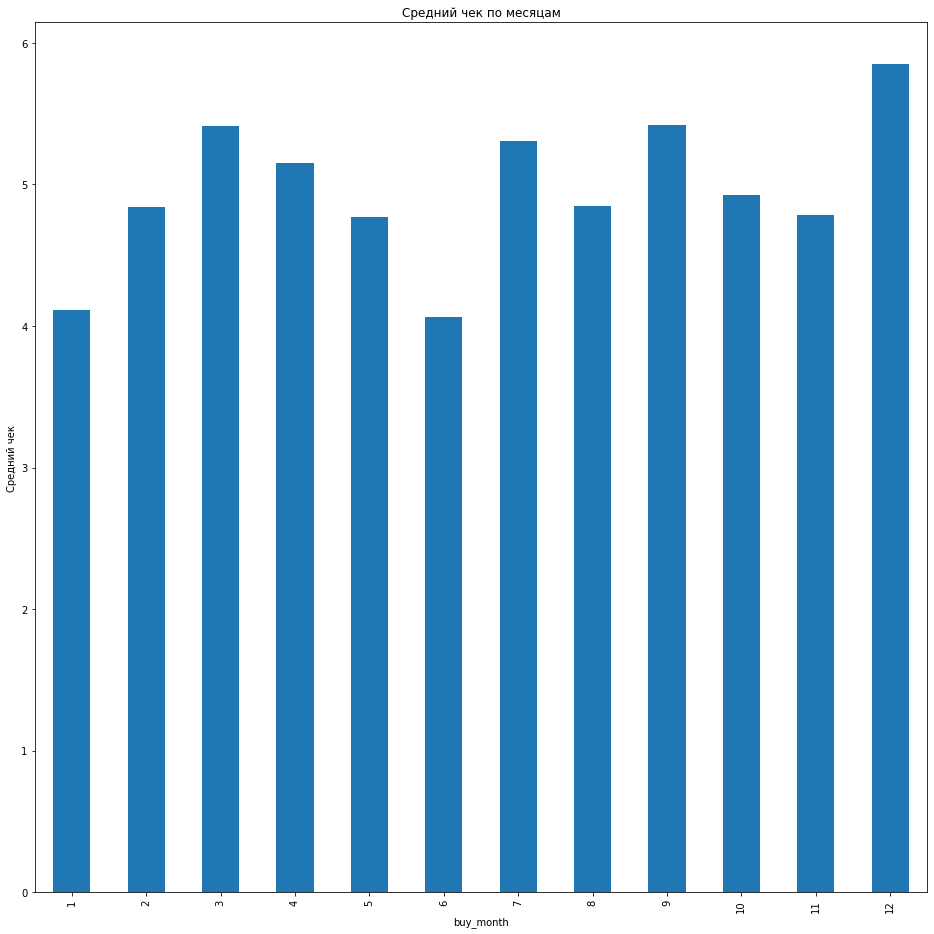

In [72]:
new_orders_pivot['revenue'].plot(kind='bar', title = 'Средний чек по месяцам')
plt.ylabel('Средний чек')
plt.show()

Видны некоторые сезонные колебания. Всплески - март (возможно из-за 8 марта), июль (туристы), декабрь (новогодние праздники).

In [73]:
# Посчитаем средний чек для каждой когорты по месяцам
cohort_mean_purchases = cohort_customers_count.pivot_table(index = 'first_visits_month',
                                  columns = 'buy_month',
                                  values = 'mean_purchase')
cohort_mean_purchases

buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_visits_month,,,,,,,,,,,,,
2017-06-01,4.060106,6.885220,5.365165,8.783009,7.636802,6.599252,6.979900,6.902158,6.247736,10.948553,11.913568,6.557177,NaN
2017-07-01,NaN,4.997414,5.756957,5.435784,5.015102,4.411406,4.694588,4.140845,4.937821,4.798146,6.793448,5.369655,NaN
2017-08-01,NaN,NaN,4.618378,4.512760,4.884634,5.286089,5.000247,4.980374,4.771078,8.594690,10.007711,4.472857,NaN
2017-09-01,NaN,NaN,NaN,4.903651,7.521301,6.415289,37.959745,9.544296,9.948177,4.983711,5.065773,3.737232,NaN
2017-10-01,NaN,NaN,NaN,NaN,4.300309,6.154814,3.727584,4.502340,4.259061,4.667534,4.419160,4.151266,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.225918,3.482480,3.639160,4.320284,3.647171,5.054500,3.992000,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.225871,3.747909,16.024046,20.495280,12.898850,11.279304,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.604425,4.317920,4.567686,3.254043,4.288374,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.615776,4.804988,5.101462,6.482086,NaN


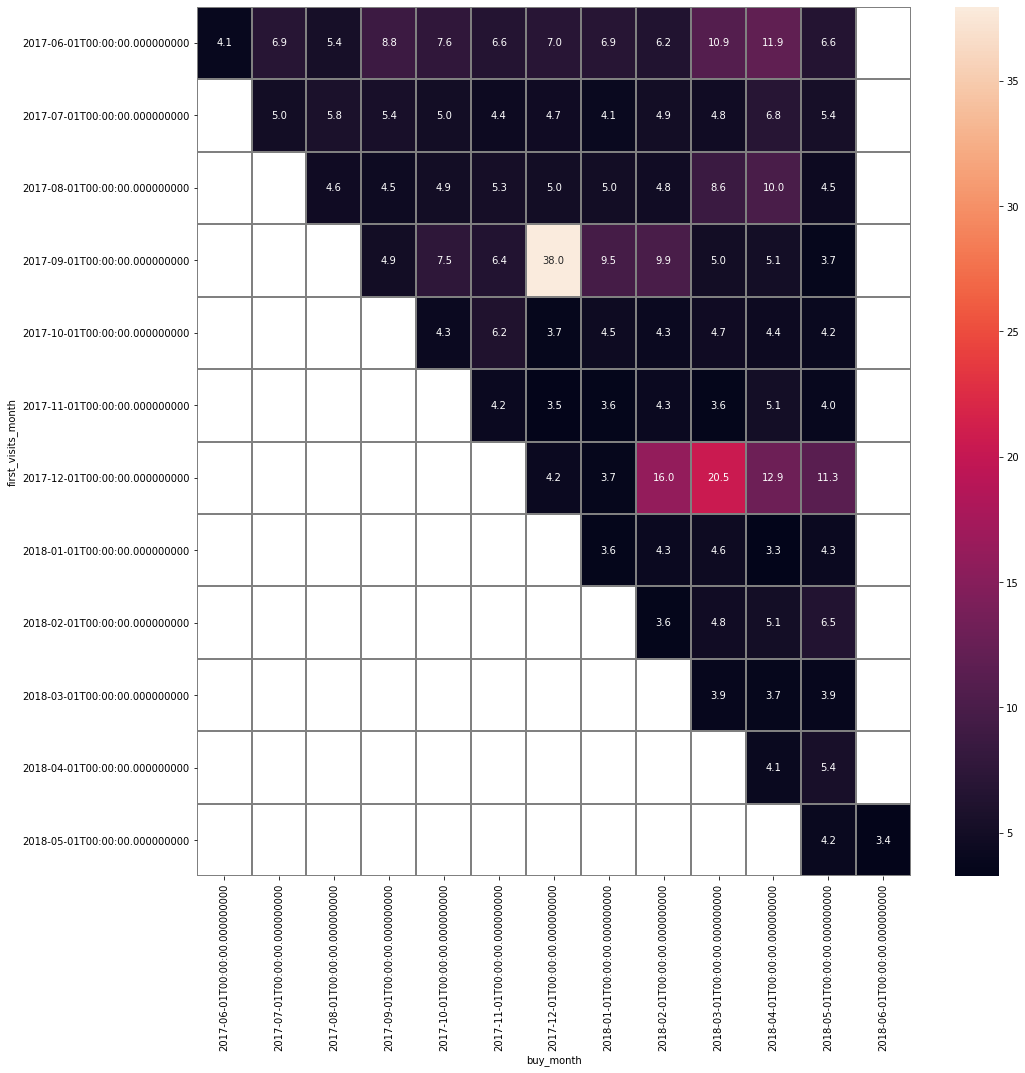

In [74]:
# Построим тепловую карту среднего чека для каждой когорты по месяцам
sns.heatmap(cohort_mean_purchases, annot = True, fmt = '.1f', linewidths = 1, linecolor = 'gray')
plt.rcParams["figure.figsize"] = (16,16)
plt.show()

Средний чек стабильно низкий, с редкими всплесками по месяцам

### 2.3. Маркетинг

In [75]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [76]:
# Посчитаем суммарные затраты на маркетинг
costs['costs'].sum()

329131.62

<b>Всего на маркетинг за рассматриваемый период было потрачено 329131.62</b>

In [77]:
# Переведем дату покупки в формат месяца
costs['dt'] = costs['dt'].astype('datetime64[M]')
costs.head(3)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-01,62.25
2,1,2017-06-01,36.53


In [78]:
# Посчитаем затраты по месяцам
costs.groupby('dt')['costs'].sum()

dt
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

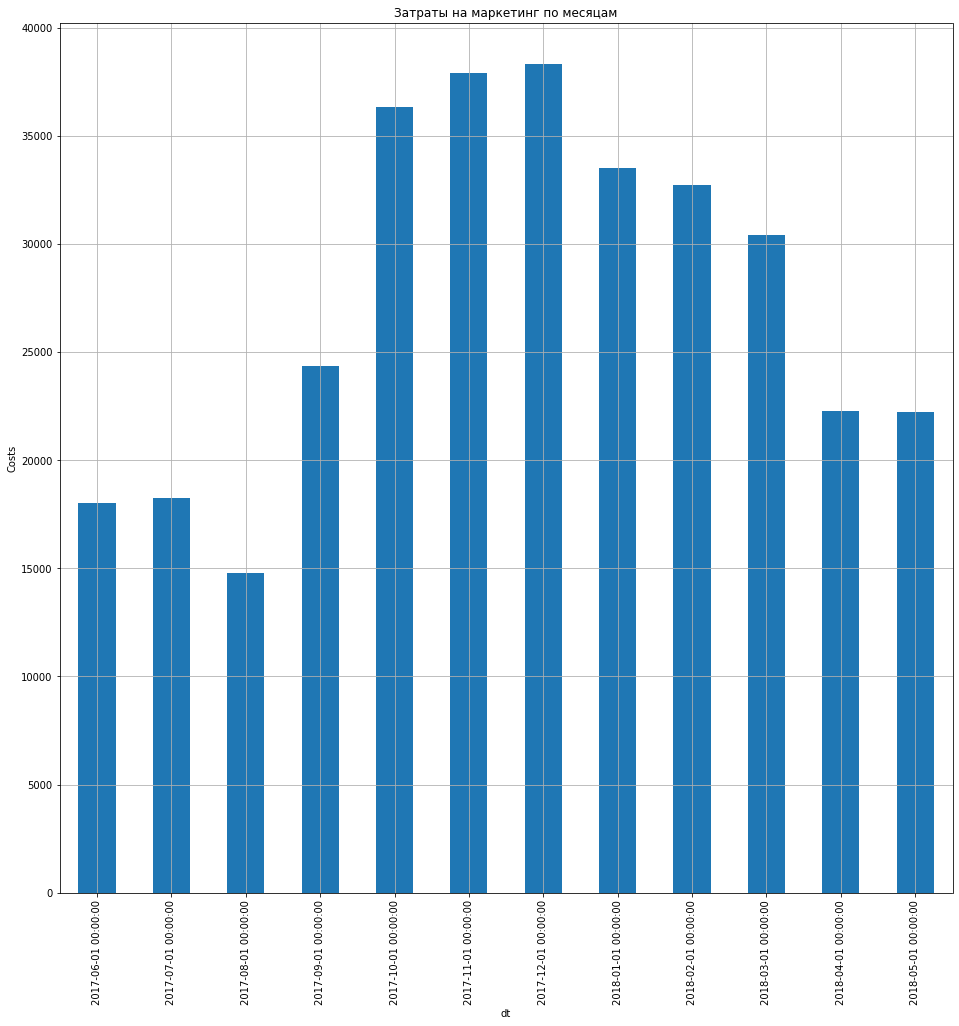

In [79]:
# Построим график затрат на маркетинг по месяцам
costs.groupby('dt')['costs'].sum().plot(kind = 'bar', title = 'Затраты на маркетинг по месяцам',
                                       grid = True)
plt.ylabel('Costs')
plt.show()

In [80]:
# Посчитаем затраты на маркетинг по источникам
costs_sources = costs.groupby(['source_id'])['costs'].sum()
costs_sources

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

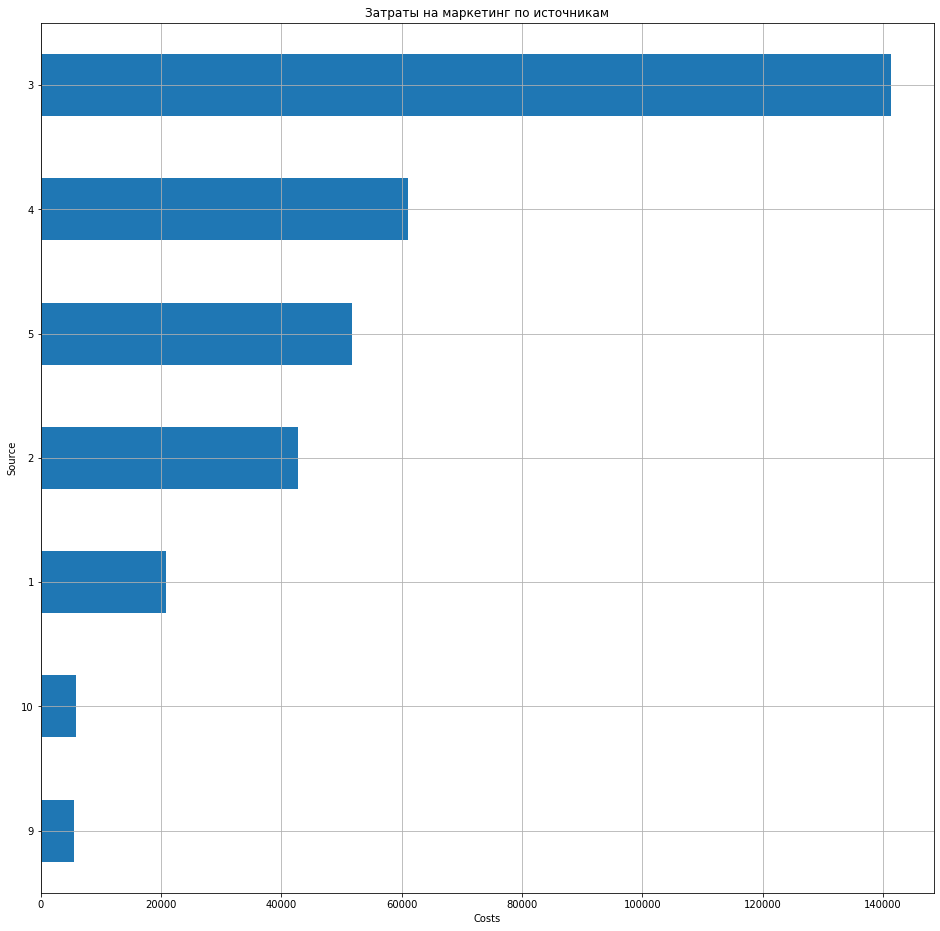

In [81]:
# Построим график затрат на маркетинг по источникам
costs.groupby(['source_id'])['costs'].sum().sort_values(ascending = True).plot(kind = 'barh', title = 'Затраты на маркетинг по источникам',
                                       grid = True)
plt.ylabel('Source')
plt.xlabel('Costs')
plt.show()

<b>Больше всего средств затрачено на 3-й источник<b>

In [82]:
# Посчитаем кол-во уникальных покупателей и доход по источникам
sources_customers = good_orders_visits.groupby('source_id').agg({'uid':'nunique', 'revenue' : 'sum'})
sources_customers['ltv'] = sources_customers['revenue'] / sources_customers['uid']
sources_customers

,uid,revenue,ltv
source_id,,,
1,3743,38560.06,10.301913
2,4323,65152.26,15.071076
3,9138,44317.68,4.849823
4,9823,52479.75,5.342538
5,6839,40357.91,5.901142
7,1,1.22,1.220000
9,1415,7076.98,5.001399
10,1241,4111.34,3.312925


In [83]:
# Переведем Series в DataFrame
cost_sources = costs_sources.to_frame()
cost_sources

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


In [84]:
# Соединим таблицы в одну и посчитаем затраты на привлечение одного клиента по источникам
cost_sources = pd.DataFrame(costs_sources)
sources_customers = sources_customers.join(cost_sources, how = 'inner')
sources_customers['cac'] = sources_customers['costs'] / sources_customers['uid']
sources_customers['romi'] = sources_customers['ltv'] / sources_customers['cac']
sources_customers.sort_values(by = ['romi'], ascending = False)

,uid,revenue,ltv,costs,cac,romi
source_id,,,,,,
1,3743,38560.06,10.301913,20833.27,5.565928,1.850889
2,4323,65152.26,15.071076,42806.04,9.901929,1.522034
9,1415,7076.98,5.001399,5517.49,3.899286,1.282645
4,9823,52479.75,5.342538,61073.60,6.217408,0.859287
5,6839,40357.91,5.901142,51757.10,7.567934,0.779756
10,1241,4111.34,3.312925,5822.49,4.691773,0.706114
3,9138,44317.68,4.849823,141321.63,15.465269,0.313594


Text(0, 0.5, 'Source')

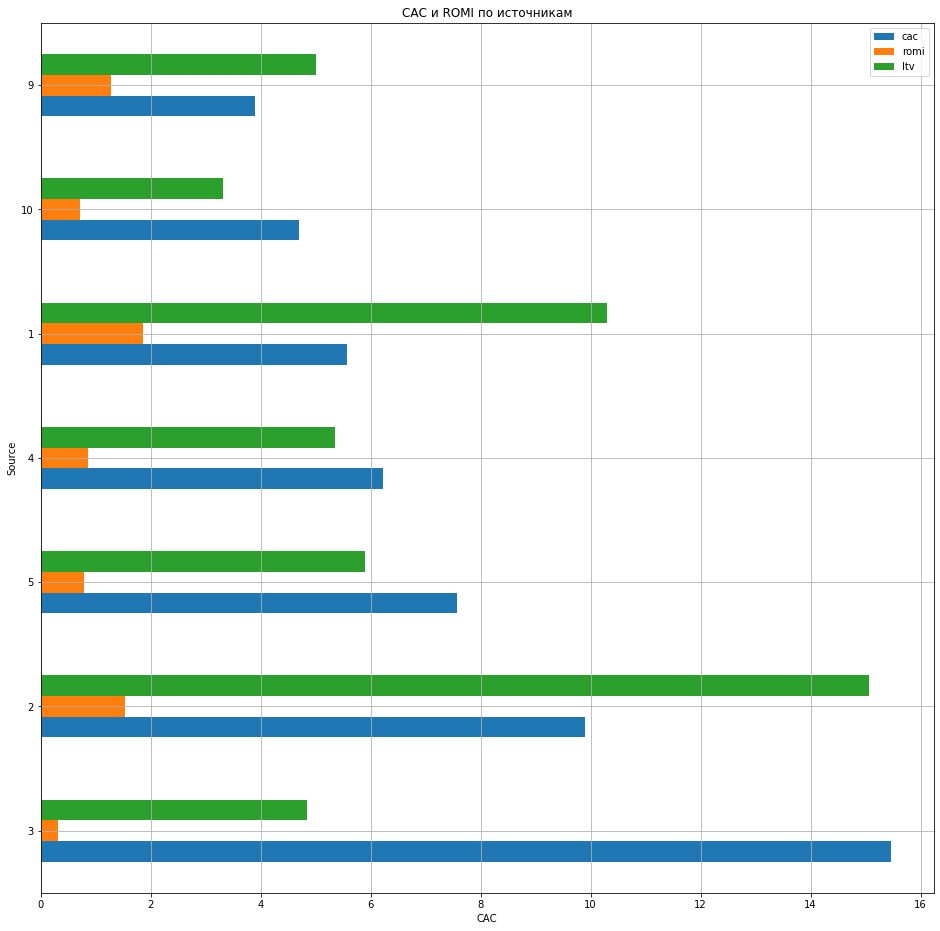

In [85]:
# Построим график
sources_customers.sort_values(by = 'cac', ascending = False)[['cac','romi', 'ltv']].plot(kind = 'barh', grid = True, title = 'CAC и ROMI по источникам')
plt.xlabel('CAC')
plt.ylabel('Source')

<b>9-й и 10-й источники имеют самые низкие показатели стоимости привлечения одного покупателя (соответственно 3.89 и 4.69)</b>

<b>Однако, по показателю ROMI наиболее эффективные 1, 2 и 9 источники. Самый невыгодный 3 источник</b>

In [86]:
sources_devices_customers = good_orders_visits.groupby(['buy_month','source_id', 'device']).agg({'uid':'nunique', 'revenue' : 'sum'})
sources_devices_customers['ltv'] = sources_devices_customers['revenue'] / sources_devices_customers['uid']
sources_devices_customers

uid  revenue       ltv
buy_month  source_id device                         
2017-06-01 1         desktop  169  1035.53  6.127396
                     touch     34   132.92  3.909412
           2         desktop  223  1302.57  5.841121
                     touch     48   249.19  5.191458
           3         desktop  503  2237.20  4.447714
...                           ...      ...       ...
2018-05-01 9         desktop   73   316.30  4.332877
                     touch     12    31.15  2.595833
           10        desktop   96   421.89  4.394688
                     touch     33    97.86  2.965455
2018-06-01 4         desktop    1     3.42  3.420000

[170 rows x 3 columns]

In [87]:
sources_cac = sources_customers.drop(labels = ['uid', 'revenue', 'ltv', 'costs', 'romi'], axis = 1)
sources_cac

,cac
source_id,
1,5.565928
2,9.901929
3,15.465269
4,6.217408
5,7.567934
9,3.899286
10,4.691773


In [88]:
sources_devices_customers = sources_devices_customers.join(sources_cac, on = 'source_id', how = 'outer')
sources_devices_customers['romi'] = sources_devices_customers['ltv'] / sources_devices_customers['cac']
sources_devices_customers

uid  revenue       ltv       cac      romi
buy_month  source_id device                                             
2017-06-01 1         desktop  169  1035.53  6.127396  5.565928  1.100876
                     touch     34   132.92  3.909412  5.565928  0.702383
2017-07-01 1         desktop  181  1653.59  9.135856  5.565928  1.641389
                     touch     41   331.42  8.083415  5.565928  1.452303
2017-08-01 1         desktop  126   911.11  7.231032  5.565928  1.299160
...                           ...      ...       ...       ...       ...
2018-04-01 10        desktop  100   276.06  2.760600  4.691773  0.588392
                     touch     23    42.54  1.849565  4.691773  0.394215
2018-05-01 10        desktop   96   421.89  4.394688  4.691773  0.936680
                     touch     33    97.86  2.965455  4.691773  0.632054
2017-08-01 7         desktop    1     1.22  1.220000       NaN       NaN

[170 rows x 5 columns]

In [89]:
sources_devices_customers.groupby(['buy_month', 'source_id'])[['ltv', 'cac', 'romi']].mean()

ltv        cac      romi
buy_month  source_id                               
2017-06-01 1          5.018404   5.565928  0.901629
           2          5.516290   9.901929  0.557092
           3          3.840124  15.465269  0.248306
           4          4.767749   6.217408  0.766839
           5          4.620184   7.567934  0.610495
...                        ...        ...       ...
2018-05-01 4          4.764889   6.217408  0.766379
           5          4.559990   7.567934  0.602541
           9          3.464355   3.899286  0.888459
           10         3.680071   4.691773  0.784367
2018-06-01 4          3.420000   6.217408  0.550068

[86 rows x 3 columns]

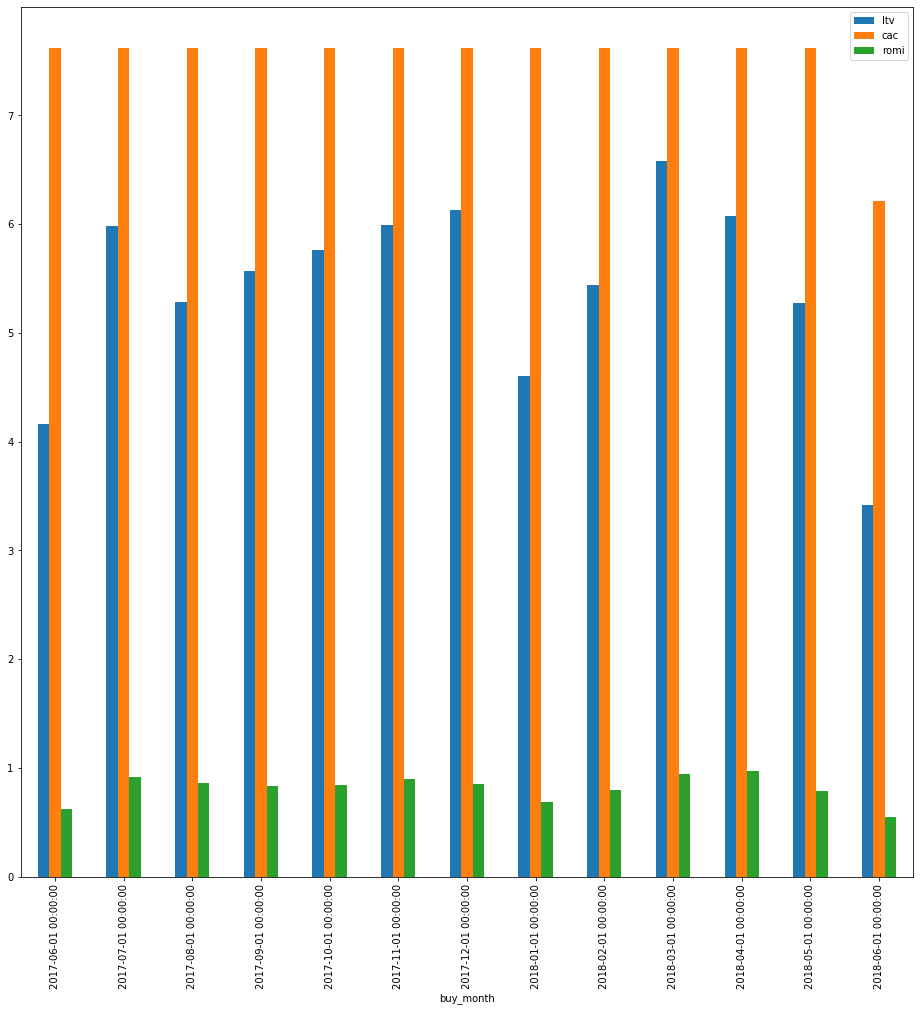

In [90]:
sources_devices_customers.groupby(['buy_month'])[['ltv', 'cac', 'romi']].mean().plot(kind = 'bar')

<b>В целом, по времени средние показатели достаточно ровные. Каких-то серьезных сезонных или других всплесков метрик не замечено.</b>

LTV после небольшого провала росла с августа 2017 до конца года, затем опять спад в начале года и снова рост до марта 2018, затем опять спад к июню.

In [91]:
sources_devices_customers.groupby(['source_id','device'])[['ltv', 'cac', 'romi']].mean()

ltv        cac      romi
source_id device                                 
1         desktop   9.378750   5.565928  1.685029
          touch     6.573278   5.565928  1.180985
2         desktop  12.675497   9.901929  1.280104
          touch     6.650884   9.901929  0.671676
3         desktop   4.595182  15.465269  0.297129
          touch     4.338610  15.465269  0.280539
4         desktop   4.795663   6.217408  0.771328
          touch     5.039223   6.217408  0.810502
5         desktop   5.666750   7.567934  0.748784
          touch     4.207577   7.567934  0.555974
7         desktop   1.220000        NaN       NaN
9         desktop   4.361764   3.899286  1.118606
          touch     3.848367   3.899286  0.986941
10        desktop   3.389842   4.691773  0.722508
          touch     2.707756   4.691773  0.577129

По 1-му и 2-му источнику у пользователей с desktop метрики выше чем у мобильных пользователей. Остальные рекламные источники дают довольно ровные метрики.

## Общие выводы

### Продукт

- Средняя MAU составляет 23288 уникальных пользователей в месяц
- В день сервисом пользуются в среднем 908 уникальных посетителей
- В среднем в день происходит 987 сессий доступа к сервису
- Кол-во сессий на одного пользователя невелико, чуть более 1.2 и не растет

<i>Данные метрики на мой взгляд немного ниже нормальных</i>
- ASL будет 505 секунд (или 8.4 минуты) 

<i>Это неплохой показатель, но нужно стремиться к его дальнейшему росту</i>

<i>Плохие показатели метрик Retention Rate и Churn Rate говорят о том, что либо с сервисом что-то не то (каждый месяц регистрируется много уникальных пользователей, но продолжают пользоваться им менее 10%, либо о том что пользователям не напоминают о сервисе, и они забывают о нем и перестают пользоваться</i>

<b>Рекомендация отделу маркетинга - задействовать две стратегии:
- Протестировать и улучшить интерфейс сервиса, пользовательский опыт (особенно обратить внимание на мобильную версию)
- Ежемесячно направлять зарегистрированным пользователям сервиса email рассылку с интересным и полезным контентом, с призывом воспользоваться сервисом
- Использовать стимулирующие акции по привлечению новых клиентов "приведи друга", промокоды</b>

### Продажи

- Средняя конверсия посетителей в покупателей составляет 16%
- Средняя LTV для одного покупателя составляет 9.22
- В первый же месяц использования сервиса, часть посетителей начинают совершать покупки. На второй месяц и далее с течением времени их активность снижается
- Больше половины покупателей начинают делать покупки в первый день пользователей сервисом
- Доля повторных клиентов в среднем составляет около 17%
- Основная масса пользователей делает покупки в первый месяц, в последующие месяцы кол-во покупок крайне мало
- Средний чек составляет 4.99 Средний чек во всех когортах и всех месяцах стабильно низкий, с редкими всплесками

<i>Метрики продаж очень низкие</i>

<b>Рекомендация отделу маркетинга:
- Проанализировать поведение пользователей, найти причины низкой конверсии - неудобный интерфейс покупки, ошибки технического характера
- Направлять пользователям, которые незакончили процесс покупки email с напоминанием завершить покупку
- Предложить пользователям стимулирующие акции и скидки, направленные на увеличение покупок</b>
    
### Маркетинг

- Всего на маркетинг за рассматриваемый период было потрачено 329131.62
- Больше всего средств затрачено на 3-й источник
- 9-й и 10-й источники имеют самые низкие показатели стоимости привлечения одного покупателя (соответственно 3.89 и 4.69)
- По показателю ROMI наиболее эффективные 1, 2 и 9 источники. Самый невыгодный 3 источник
- По времени средние показатели LTV, CAC и ROMI достаточно ровные. Серьезных сезонных или других всплесковне замечено

<i>Больше всего средств потрачено на самый неэффективный источник привлечения клиентов</i>

<b>Рекомендация отделу маркетинга:
- Перенаправить маркетинговые вложения на 1, 2 и 9 источники привлечения клиентов
- Проанализировать еще раз все метрики через 2-3 месяца, для отслеживания эффекта
- Проводить постоянный анализ всех метрик ежемесячно, для выявления неэффективных источников, аномалий
- Не снижать маркетинговую активность в весенне-летний период, для избежания оттока клиентов в эти месяцы
- В рекламе уделить внимание мобильным пользователям
